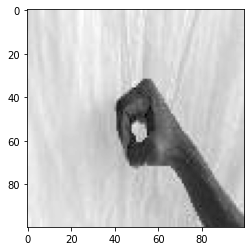

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf

DATADIR = "/content/drive/MyDrive/alldata"
CATEGORIES = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31","32","33","34","35","36","37","38","39","40","41","42","43","44","45","46","47","48","49","50","51","52","53","54","55","56","57","58"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path):  # iterate over each image 
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!
        break   # we just want one for now so break
    break
     #...and one more!

# printing image array


In [ ]:
print(img_array)
print(img_array.shape)

[[176 182 185 ... 183 185 186]
 [176 182 185 ... 181 183 185]
 [176 182 185 ... 180 182 184]
 ...
 [199 204 191 ...  89  95 100]
 [198 202 190 ...  76  88  94]
 [196 201 189 ...  67  83  88]]
(100, 100)


# Loading data and preprocess them
#resize them into 60x60
#Convert into grayscale


In [ ]:
training_data = []
IMG_SIZE=60
def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):
          try:  
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
          except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 500/500 [01:04<00:00,  7.71it/s]

37950


#Suffling data which loaded

In [ ]:
import random

random.shuffle(training_data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#store image feature in x list and image label in y list

In [ ]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    
    y.append(label)
    #np.array((y,label))
   

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)


#print the shape of x

In [ ]:
X.shape

(37950, 60, 60, 1)

#pickle our data for easy use

In [ ]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

#Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

#Proposed Model 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


import pickle

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
X = np.array(X)
y = np.array(y)
number_class=59
model = Sequential()

model.add(Conv2D(16, (3, 3),padding='same',input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(256, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(512, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(84))
model.add(Dropout(0.5))

model.add(Dense(number_class))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#history=model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)

#Cross validation part(10fold stratified cross validation)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset

import numpy as np
from sklearn.model_selection import StratifiedKFold

X = np.array(X)
y = np.array(y)
skf = StratifiedKFold(n_splits=10)
score_model=[]
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
	
	

TRAIN: [ 2771  2777  2881 ... 37947 37948 37949] TEST: [   0    1    2 ... 4694 4801 4901]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [2771 2777 2881 ... 8627 8734 8749]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [ 6281  6316  6322 ... 12944 12957 13019]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [10183 10258 10266 ... 16736 16772 16859]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [13878 13897 14015 ... 20456 20479 20599]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [17449 17468 17595 ... 24120 24125 24146]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [20362 20430 20451 ... 27645 27658 27665]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [24463 24568 24811 ... 31507 31511 31518]
TRAIN: [    0     1     2 ... 37947 37948 37949] TEST: [28747 28795 28883 ... 35122 35135 35240]
TRAIN: [    0     1     2 ... 35122 35135 35240] TEST: [32727 32817 32948 ... 37947 37948 37949]


#Model checkpoint and Early stopping set

In [ ]:
#model checkpoint
from keras.callbacks import ModelCheckpoint,EarlyStopping
ES= EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)

MC=ModelCheckpoint(filepath="cnnfordigits.h5",monitor='val_accuracy',
                   min_delta=0.01,patience=5,verbose=1,save_best_only=True)
CB=[ES,MC]

In [ ]:
hist=model.fit(X_train, y_train, epochs=100,validation_data=(X_test,y_test),callbacks= CB)

Epoch 1/100
1068/1068 [==============================] - 523s 488ms/step - loss: 1.1114 - accuracy: 0.6932 - val_loss: 0.2612 - val_accuracy: 0.9162

Epoch 00001: val_accuracy improved from -inf to 0.91621, saving model to cnnfordigits.h5
Epoch 2/100
1068/1068 [==============================] - 528s 494ms/step - loss: 0.2572 - accuracy: 0.9165 - val_loss: 0.2819 - val_accuracy: 0.9209

Epoch 00002: val_accuracy improved from 0.91621 to 0.92095, saving model to cnnfordigits.h5
Epoch 3/100
1068/1068 [==============================] - 520s 487ms/step - loss: 0.1576 - accuracy: 0.9511 - val_loss: 0.1366 - val_accuracy: 0.9615

Epoch 00003: val_accuracy improved from 0.92095 to 0.96153, saving model to cnnfordigits.h5
Epoch 4/100
1068/1068 [==============================] - 522s 489ms/step - loss: 0.1161 - accuracy: 0.9654 - val_loss: 0.5029 - val_accuracy: 0.8854

Epoch 00004: val_accuracy did not improve from 0.96153
Epoch 5/100
1068/1068 [==============================] - 519s 486ms/step

#Fit the model

In [ ]:
hist=model.fit(X_train, y_train, epochs=50,validation_data=(X_test,y_test))

Epoch 1/50
1068/1068 [==============================] - 492s 460ms/step - loss: 0.0631 - accuracy: 0.9825 - val_loss: 0.2209 - val_accuracy: 0.9441
Epoch 2/50
1068/1068 [==============================] - 482s 452ms/step - loss: 0.0603 - accuracy: 0.9828 - val_loss: 0.0811 - val_accuracy: 0.9842
Epoch 3/50
1068/1068 [==============================] - 503s 471ms/step - loss: 0.0505 - accuracy: 0.9874 - val_loss: 0.1213 - val_accuracy: 0.9721
Epoch 4/50
1068/1068 [==============================] - 496s 465ms/step - loss: 0.0492 - accuracy: 0.9867 - val_loss: 0.0828 - val_accuracy: 0.9810
Epoch 5/50
1068/1068 [==============================] - 496s 464ms/step - loss: 0.0403 - accuracy: 0.9898 - val_loss: 0.1117 - val_accuracy: 0.9752
Epoch 6/50
1068/1068 [==============================] - 494s 463ms/step - loss: 0.0444 - accuracy: 0.9886 - val_loss: 0.2048 - val_accuracy: 0.9552
Epoch 7/50
1068/1068 [==============================] - 486s 455ms/step - loss: 0.0367 - accuracy: 0.9899 - val_

#plot accuracy curve


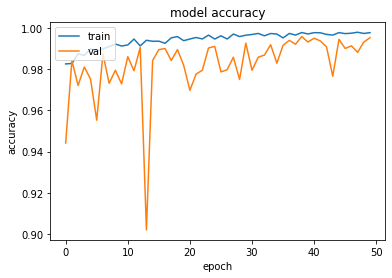

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#plot loss curve

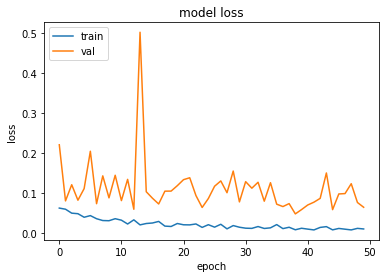

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Evaluate the cross validation score

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
score_model.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(score_model), numpy.std(score_model)))

accuracy: 99.53%
99.53% (+/- 0.00%)


In [ ]:
print(scores)

[0.06519439071416855, 0.9952569007873535]


In [ ]:
model.save('newcnnforalldata.h5')


In [ ]:
new_model = tf.keras.models.load_model('newcnnforalldata.h5')


#prediction

In [ ]:
predictions = new_model.predict(X_test)
print(predictions)

[[1.3326472e-36 1.1032063e-30 3.0925727e-34 ... 6.9283450e-27
  1.6793972e-33 2.4808685e-35]
 [7.9764429e-37 5.9432558e-30 4.2509922e-35 ... 1.3541701e-29
  6.6785717e-35 8.4318656e-32]
 [1.0077805e-32 1.7415389e-27 6.0577420e-32 ... 1.4257858e-26
  1.4962544e-31 5.1475417e-30]
 ...
 [2.3290738e-22 2.6577410e-18 1.1431243e-17 ... 6.4252542e-13
  1.2535144e-17 1.9480159e-18]
 [7.4934795e-17 1.1223198e-16 1.0000000e+00 ... 7.0487769e-15
  1.8433991e-21 4.3324737e-19]
 [4.2747091e-24 6.5948997e-20 4.3031081e-18 ... 1.2655657e-23
  8.0441488e-24 4.7586026e-18]]


In [ ]:
import numpy as np

print(np.argmax(predictions[7]))

30


In [ ]:
y_classes=[np.argmax(element) for element in predictions]
y_classes[:5]

[18, 18, 18, 18, 36]

In [ ]:
y_test[:5]

array([18, 18, 18, 18, 36])

#testing with image from our dataset

In [ ]:
#prepare image to prediction
filepath="/content/drive/MyDrive/alldata/20/Oww100.jpg"
def prepare(filepath):
    image = cv2.imdecode(np.fromfile(filepath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (60, 60))
    image=image.reshape(-1, 60, 60, 1)
    image=image.astype('float32')/255.0
    return  image

#use this function to predict images
def predict(my_model, filepath):
    prediction = model.predict([prepare(filepath)]) 
    category = np.argmax(prediction[0])
    return  CATEGORIES[category]

In [ ]:
category = predict(model,"/content/drive/MyDrive/alldata/20/Oww100.jpg")
print("The image class is: " + str(category))

The image class is: 20


In [ ]:
category = predict(model,"/content/drive/MyDrive/alldata/18/oi10.jpg")
print("The image class is: " + str(category))

The image class is: 18


In [ ]:
category = predict(model,"/content/drive/MyDrive/alldata/13/dirgho e193.jpg")
print("The image class is: " + str(category))

The image class is: 13


In [ ]:
category = predict(model,"/content/drive/MyDrive/alldata/24/A (325).JPG")
print("The image class is: " + str(category))

The image class is: 24


In [ ]:
category = predict(model,"/content/drive/MyDrive/alldata/54/do bindu dho101.jpg")
print("The image class is: " + str(category))

The image class is: 54
